<a href="https://colab.research.google.com/github/omkardpatil/conformal_cooling_channels_design_optimization/blob/main/PSO_QC_FE_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
import fenics
clear_output()

In [ ]:
def work(mesh, u, temp_threshold_for_fitness):
  # Define your mesh and function space
  V = FunctionSpace ( mesh, "Lagrange", 1 )

  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)

  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
  return fitness

In [ ]:
def generate_mesh_here(circle, mesh_res):
  circle_x,circle_y,circle_r = circle
  domain = Circle(Point(0.0,0.0),1.0) -Rectangle(Point(-2.0,-2.0), Point(2.0,0.0))-Rectangle(Point(-2.0,0.0), Point(0.0,2.0))\
          - Circle(Point(circle_x,circle_y),circle_r)
  mesh = generate_mesh ( domain, mesh_res )
  return mesh

In [ ]:
from fenics import *
from mshr import *
from math import *
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm



T_hot_edge = 150
T_cold_circle = 20
T_body_init = 40
point = (0.4,0.1)
threshold_dis = 0.02
temp_threshold_for_fitness=25
temp_threshold_for_stopping=35
mesh_res=20
t0=0.3 #time for which hot plastic will be in contact
#  Define time things
t_init = 0.0
t_final = 3.0
t_num = 300

u_origin=[]

def heat_implicit (circle):
  mesh  = generate_mesh_here(circle, mesh_res)

  V = FunctionSpace ( mesh, "Lagrange", 1 )

  rect_u = T_hot_edge #150.0
  def outer_circle_on ( x, on_boundary ):
    return 1-(x[0]**2+x[1]**2)<threshold_dis #x[0]+x[1]>1

  rect_bc = DirichletBC ( V, rect_u, outer_circle_on )

  circle_u = T_cold_circle#20.0
  def inner_circle_on ( x, on_boundary ):
    r = sqrt ( ( x[0] - circle_x ) ** 2 + ( x[1] - circle_y ) ** 2 )
    return abs(circle_r-r)< threshold_dis

  circle_bc = DirichletBC ( V, circle_u, inner_circle_on )
  bc = [ rect_bc, circle_bc ]
  bc_new = [circle_bc]

#  Define the trial functions (u) and test functions (v).
  u = TrialFunction ( V )
  v = TestFunction ( V )


#  The diffusivity is a constant.
  k = Constant ( 1.0 )
#  The source term is zero.
  f = Constant ( 0.0 )
  dt = ( t_final - t_init ) / t_num

#  Create U_INIT.
  u_init = Expression ( str(T_body_init), degree = 10 )
  u_old = interpolate ( u_init, V )
  fvt = ( u_old + dt * f ) * v * dx
  Auvt = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
  u = Function ( V )
  t = t_init

  v_min=20
  v_max=100
  for j in range ( 0, t_num + 1):
    t = t + dt
    if(t>t0):
      bc=bc_new
    solve ( Auvt == fvt, u, bc )
    u_old.assign ( u )
    max_value= u.vector().max()
    if(max_value<temp_threshold_for_stopping):
      fitness1 = work(mesh, u, temp_threshold_for_fitness)
      fitness2 = exp(t)
      return fitness1*fitness2
  fitness1 = work(mesh, u, temp_threshold_for_fitness)
  fitness2 = exp(t)
  return fitness1*fitness2

def heat_implicit_test (circle):
  level = 30
  set_log_level ( level )
  return heat_implicit(circle)

In [ ]:
#test
circle_x = 0.4
circle_y = 0.4
circle_r = 0.1
circle = [circle_x,circle_y,circle_r]
ans =heat_implicit_test (circle)
clear_output()
print(ans)

822534.994743916


Generation number :  49
[0.77640931 0.21810655 0.19951566]
[0.7910811  0.26134273 0.17416497]
[0.81268846 0.16899597 0.16899597]
[0.81824737 0.19609243 0.16233804]
[0.81906162 0.17050191 0.16629573]
[0.77397751 0.18112266 0.18112266]
[0.86701135 0.11843446 0.11843446]
[0.9        0.19335636 0.08112859]
[0.80572868 0.1924957  0.17556913]
[0.79653449 0.23829156 0.17465918]


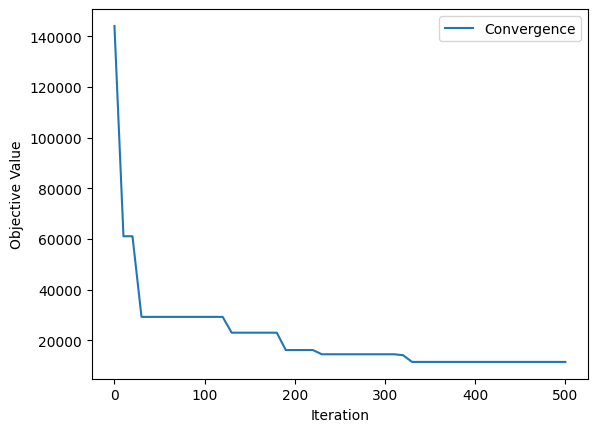

Best Position: [0.80265086 0.18888338 0.17934867], Best Value: 11461.540742474444


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Objective function with weight decay (sum of absolute differences)
def objective_function_3d(x):
    print(x)
    ans = heat_implicit_test(x)
    return ans #np.abs(x[0]-0.3) + np.abs(x[1]+0.3) + np.abs(x[2])

# Particle Swarm Optimization function with constraint on x[0]
def particle_swarm_optimization_constrained(objective_function, limits, num_particles=10, num_dimensions=3, num_iterations=100, inertia_weight=0.9, cognitive_param=1.5, social_param=1.5, weight_decay=0.995):

    # Initialize particles within the specified range
    particles_position=np.ones([num_particles, num_dimensions])
    particles_position[:,0] = np.random.uniform(limit[0], limit[1], size=(num_particles))
    particles_position[:,1] = np.random.uniform(limit[0], limit[1], size=(num_particles))
    particles_position[:,2] = np.random.uniform(limit[0], limit[1], size=(num_particles))

    particles_position[:, 0] = np.clip(particles_position[:, 0], limit[0], limit[1])
    x = particles_position[:, 0]
    for i in range(x.shape[0]):
      particles_position[i, 1] = np.clip(particles_position[i, 1], limit[0], sqrt(1-x[i]**2)-0.1)
    y = particles_position[:, 1]
    for i in range(x.shape[0]):
      r_min=0.05
      r_max=min(x[i], y[i], sqrt(1-y[i]**2)-x[i], sqrt(1-x[i]**2)-y[i])
      #print('original ', particles_position[i, 2], 'r min ', r_min, 'r max ', r_max)
      #if(r_max<0.001):
        #print(x[i], y[i], sqrt(1-y[i]**2), sqrt(1-y[i]**2)-x[i], sqrt(1-x[i]**2),sqrt(1-x[i]**2)-y[i])
        # 0.755 0.655 0.755 -1.1102230246251565e-16 0.6557204459409025 0.0

      particles_position[i, 2] = np.clip(particles_position[i, 2], r_min, r_max)

    particles_velocity = np.random.rand(num_particles, num_dimensions)/10
    personal_best_positions = particles_position.copy()
    personal_best_values = np.apply_along_axis(objective_function, 1, personal_best_positions)

    # Global best
    global_best_index = np.argmin(personal_best_values)
    global_best_position = personal_best_positions[global_best_index]
    global_best_value = personal_best_values[global_best_index]

    # Lists to store the history for convergence plot
    convergence_history = [global_best_value]

    # List to store values of x and gb with iterations
    x_list = [particles_position.copy()]
    x_gb_list=[global_best_position.copy()]

    # Particle Swarm Optimization loop
    for _ in range(num_iterations):
        clear_output()
        print("Generation number : ", _)
        r1, r2 = np.random.rand(num_particles, 1), np.random.rand(num_particles, 1)
        cognitive_component = cognitive_param * r1 * (personal_best_positions - particles_position)
        social_component = social_param * r2 * (global_best_position - particles_position)
        particles_velocity = inertia_weight * particles_velocity + cognitive_component + social_component
        particles_velocity *= weight_decay
        particles_position += particles_velocity

        # Enforce constraint on x[0]
        particles_position[:, 0] = np.clip(particles_position[:, 0], limit[0], limit[1])
        x = particles_position[:, 0]
        for i in range(x.shape[0]):
          particles_position[i, 1] = np.clip(particles_position[i, 1], limit[0], sqrt(1-x[i]**2)-0.1)
        y = particles_position[:, 1]
        for i in range(x.shape[0]):
          r_min=0.05
          r_max=min(x[i], y[i], sqrt(1-y[i]**2)-x[i], sqrt(1-x[i]**2)-y[i])
          particles_position[i, 2] = np.clip(particles_position[i, 2], r_min, r_max)

        current_values = np.apply_along_axis(objective_function, 1, particles_position)
        update_indices = current_values < personal_best_values
        personal_best_positions[update_indices] = particles_position[update_indices]
        personal_best_values[update_indices] = current_values[update_indices]
        global_best_index = np.argmin(personal_best_values)
        global_best_position = personal_best_positions[global_best_index]
        global_best_value = personal_best_values[global_best_index]

        convergence_history.append(global_best_value)
        x_list.append(particles_position.copy())
        x_gb_list.append(global_best_position.copy())

    x_array = np.array(x_list)
    x_gb_array = np.array(x_gb_list)
    x_values = np.arange(len(convergence_history))
    x_values = [x * 10 for x in x_values]


    # Plot the convergence
    plt.plot(x_values, convergence_history, label='Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.show()

    return global_best_position, global_best_value, x_array, x_gb_array

# Example usage with constraint on x
n_it=50
np_=10
limit=[0.1, 0.9]
best_position, best_value, x_array, x_gb_array = particle_swarm_optimization_constrained(objective_function_3d, limit, num_particles=np_, num_iterations=n_it)
print(f"Best Position: {best_position}, Best Value: {best_value}")

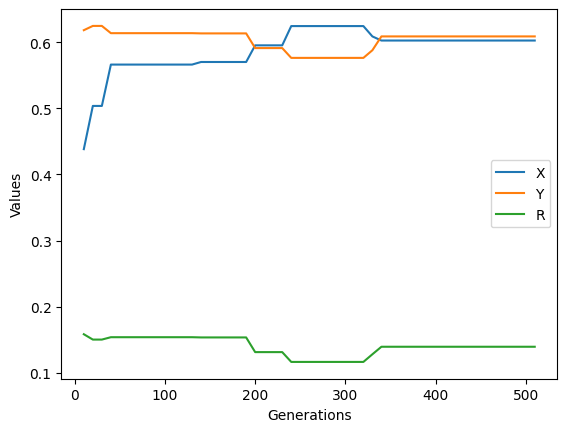

In [ ]:
import matplotlib.pyplot as plt

# Assuming u is a list of tuples with x, y, z values
u = x_gb_array

# Extracting x, y, z values
x_values = np.array([point[0] for point in u])
y_values = np.array([point[1] for point in u])
z_values = np.array([point[2] for point in u])

# Generating positions in the list for X-axis
positions = list(range(1, len(u) + 1))
positions = [x * 10 for x in positions]

# Plotting the line plot
plt.plot(positions, x_values, label='X')
plt.plot(positions, y_values, label='Y')
plt.plot(positions, z_values, label='R')

# Adding labels and legend
plt.xlabel('Generations')
plt.ylabel('Values')
plt.legend()

# Displaying the plot
plt.show()

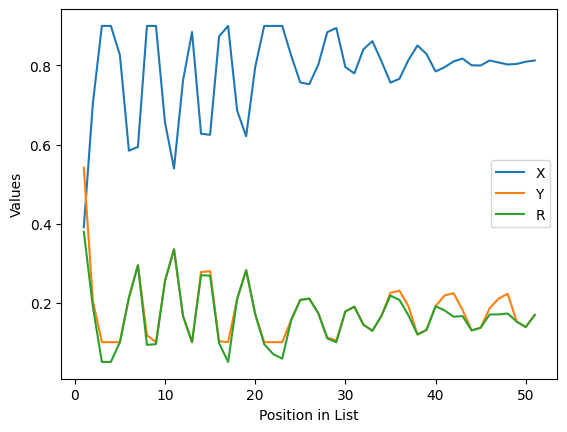

In [ ]:
partical_number=2
u = x_array[:,partical_number,:]

import matplotlib.pyplot as plt

# Extracting x, y, z values
x_values = [point[0] for point in u]
y_values = [point[1] for point in u]
z_values = [point[2] for point in u]

# Generating positions in the list for X-axis
positions = list(range(1, len(u) + 1))

# Plotting the line plot
plt.plot(positions, x_values, label='X')
plt.plot(positions, y_values, label='Y')
plt.plot(positions, z_values, label='R')

# Adding labels and legend
plt.xlabel('Position in List')
plt.ylabel('Values')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Best Position: [0.2065145  0.78529165 0.19315189], Best Value: 1273.0094110976913
# Best Position: [0.15624305 0.83538194 0.1523367 ], Best Value: 10900.443405537695